**DETECÇÃO DE FAKE NEWS UTILIZANDO O ALGORITMO NAIVE BAYES**

#Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from google.colab import files
import io

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize, sent_tokenize
import re
import string

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
uploaded = files.upload()

Saving fake_or_real_news.csv to fake_or_real_news.csv


In [4]:
# Dataset do Kaggle https://www.kaggle.com/hassanamin/textdb3

df = pd.read_csv(io.BytesIO(uploaded['fake_or_real_news.csv']))

In [5]:
print(df.shape)
print('\n')
print(df.info())
print('\n')
df.head()

(6335, 4)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB
None




,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [6]:
df.describe()

,Unnamed: 0
count,6335.000000
mean,5280.415627
std,3038.503953
min,2.000000
25%,2674.500000
50%,5271.000000
75%,7901.000000
max,10557.000000


In [7]:
df.isnull().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

<ipython-input-8-94eaa01c3401>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='pastel')


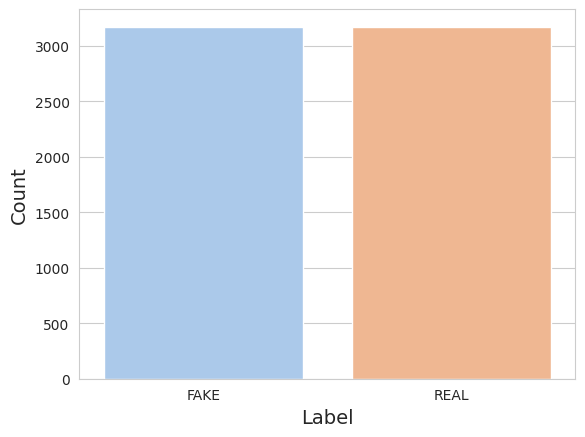

In [8]:
sns.set_style('whitegrid')
sns.countplot(x='label', data=df, palette='pastel')
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

##Pré-processamento

In [9]:
df.columns = ['ID#', 'Title', 'Text', 'Label']

df = df.replace('FAKE', 0)
df = df.replace('REAL',1)

df['Text'] = df['Title'] + ' ' + df['Text']
df.head()

,ID#,Title,Text,Label
0,8476,You Can Smell Hillary’s Fear,You Can Smell Hillary’s Fear Daniel Greenfield...,0
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Watch The Exact Moment Paul Ryan Committed Pol...,0
2,3608,Kerry to go to Paris in gesture of sympathy,Kerry to go to Paris in gesture of sympathy U....,1
3,10142,Bernie supporters on Twitter erupt in anger ag...,Bernie supporters on Twitter erupt in anger ag...,0
4,875,The Battle of New York: Why This Primary Matters,The Battle of New York: Why This Primary Matte...,1


In [10]:
news = df.drop(['ID#','Title'], axis=1)
news.head()

,Text,Label
0,You Can Smell Hillary’s Fear Daniel Greenfield...,0
1,Watch The Exact Moment Paul Ryan Committed Pol...,0
2,Kerry to go to Paris in gesture of sympathy U....,1
3,Bernie supporters on Twitter erupt in anger ag...,0
4,The Battle of New York: Why This Primary Matte...,1


In [11]:
# Letras minusculas, remover [], links, palavras que tenham numeros e pontuações
def clean_text(text):
  text = str(text).lower()
  text = re.sub('\[.*?\]', '', text)
  text = re.sub('https?;//\S+|www\,\,\S+', '', text)
  text = re.sub('<.*?>+', '', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub('\n', '', text)
  text = re.sub('\w*\d\w*', '', text)
  return text
news['Text'] = news['Text'].apply(lambda x:clean_text(x))

news.head()

,Text,Label
0,you can smell hillary’s fear daniel greenfield...,0
1,watch the exact moment paul ryan committed pol...,0
2,kerry to go to paris in gesture of sympathy us...,1
3,bernie supporters on twitter erupt in anger ag...,0
4,the battle of new york why this primary matter...,1


In [12]:
# Remover stop words

stop = stopwords.words('english')
news['Text'] = news['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

news.head()

,Text,Label
0,smell hillary’s fear daniel greenfield shillma...,0
1,watch exact moment paul ryan committed politic...,0
2,kerry go paris gesture sympathy us secretary s...,1
3,bernie supporters twitter erupt anger dnc trie...,0
4,battle new york primary matters primary day ne...,1


In [13]:
# Lemmatize (Deixa apenas a raiz das palavras)

def lemmatize_words(text):
  wnl = nltk.stem.WordNetLemmatizer()
  lem = ' '.join([wnl.lemmatize(word) for word in text.split()])
  return lem

news['Text'] = news['Text'].apply(lemmatize_words)

news.head()

,Text,Label
0,smell hillary’s fear daniel greenfield shillma...,0
1,watch exact moment paul ryan committed politic...,0
2,kerry go paris gesture sympathy u secretary st...,1
3,bernie supporter twitter erupt anger dnc tried...,0
4,battle new york primary matter primary day new...,1


## Mineração de Dados

In [14]:
# Dividir o Dataset em Treino e Teste

X_train, X_test, y_train, y_test = train_test_split(news['Text'],
                                                    news['Label'], test_size=0.25)
display(X_train.head())
print('\n')
display(y_train.head())

print("\nThere are {} documents in the training data.".format(len(X_train)))

5005    fbi director comey sent letter staff admitting...
1810    pentagon retreat enlistment bonus collection e...
2300    standard dejection irs help line midmorning li...
2181    amid immigration question gop hispanic vote la...
923     university missouri please immediately fire em...
Name: Text, dtype: object

5005    0
1810    0
2300    1
2181    1
923     1
Name: Label, dtype: int64


There are 4751 documents in the training data.


In [15]:
#Extração de Features

my_tfidf = TfidfVectorizer(stop_words='english', max_df=0.7)

tfidf_train = my_tfidf.fit_transform(X_train)
tfidf_test = my_tfidf.transform(X_test)

tfidf_train

<4751x92634 sparse matrix of type '<class 'numpy.float64'>'
	with 1175669 stored elements in Compressed Sparse Row format>

In [16]:
#Aplicação do Naive Bayes

nb_classifier = MultinomialNB()
nb_classifier.fit(tfidf_train, y_train)

pred1 = nb_classifier.predict(tfidf_test)

## Pós-processamento

In [19]:
#Métricas do Algoritmo

print(classification_report(y_test, pred1, target_names= ['Fake', 'True']))

acc_score = accuracy_score(y_test, pred1)

conf_mat = confusion_matrix(y_test, pred1)

print(acc_score)
print('\n')
print(conf_mat)

              precision    recall  f1-score   support

        Fake       0.94      0.75      0.84       746
        True       0.81      0.96      0.88       838

    accuracy                           0.86      1584
   macro avg       0.88      0.86      0.86      1584
weighted avg       0.87      0.86      0.86      1584

0.8623737373737373


[[561 185]
 [ 33 805]]


In [21]:
df1 = pd.DataFrame(X_test)
df1['Valor_Real'] = pd.DataFrame(y_test)
df1['Valor_Previsto'] = pred1

display(df1.head())

Falso_Negativo = df1[(df1.Valor_Real == 0) & (df1.Valor_Previsto == 1)]
Falso_Positivo = df1[(df1.Valor_Real == 1) & (df1.Valor_Previsto == 0)]

display(Falso_Negativo.head())
print('\n')
display(Falso_Positivo.head())

,Text,Valor_Real,Valor_Previsto
3309,house approves syrian refugee bill top dems wa...,1,1
4547,jackie mason hillary clinton untrustworthy ser...,0,1
591,james comey taken know much clinton james come...,0,0
99,obama sounding like critic admits complete str...,1,1
5077,senate pass nclb replacement shift state help ...,1,1


,Text,Valor_Real,Valor_Previsto
4547,jackie mason hillary clinton untrustworthy ser...,0,1
3354,happened election happened election john chuck...,0,1
1711,iran finland sign mous tehran iran finland sig...,0,1
3470,hillary reveals pick secretary state – woman c...,0,1
1638,hatred trump’s lie leave behind juan cole w he...,0,1


,Text,Valor_Real,Valor_Previsto
1030,cuba possible lung cancer vaccine america test...,1,0
3897,clinton camp try deflect suspicion fbi reopens...,1,0
1415,expert isil highly likely launch gas attack lo...,1,0
3666,last day washington dc america longer mask ste...,1,0
5855,hillary clinton worst nightmare hint bernie sa...,1,0


> DETECÇÃO DE FAKE NEWS UTILIZANDO O ALGORITMO NAIVE BAYES. poƌ Rodrigo Cardoso Durgieǁicz